# SteroCluster 简介及使用指南

## 简介

SteroCluster是一个用来处理来自Stero-seq 的 cellBin 文件（包含：基因-counts-坐标-cellBin编号的长数据表）的Python脚本。

具体流程参照：

1.Scanpy官方文档教程中的空间转录组部分——https://scanpy-tutorials.readthedocs.io/en/latest/spatial/basic-analysis.html 以及

2.STAGATE官方文档教程中关于Stero-seq的部分——https://stagate.readthedocs.io/en/latest/T4_Stereo.html

按要求仅处理流程到聚类为止，且未对各参数进行非必要的调整和优化

## 文件组成

文件由两个部分组成，打包为SteroCluster.zip，具体包括：

1. Python脚本 SteroCluster.py，Main.py，buildLog.py

2.测试数据 E14.5_E1S3_Dorsal_Midbrain_GEM_CellBin.tsv

目录结构为：

结果文件夹
├── 1.data                                          默认测试数据文件夹 

│   └── E14.5_E1S3_Dorsal_Midbrain_GEM_CellBin.tsv 测试输入文件     

├── SteroCluster.py                                 主运行脚本 

├── Main.py                                         主函数脚本 

└── buildLog.py                                     辅助功能脚本 



## 使用方法

### 环境依赖

编写并测试与于使用以下命令在Anaconda3中创建的虚拟环境下：（anaconda version: 4.14.0）

conda create -n scanpy -c conda-forge python=3.7 scanpy python-igraph leidenalg umap scikit-misc 

 *installation should say python 3.7 else SyntaxError: future feature annotations is not defined https://github.com/colomemaria/epiScanpy/issues/125

### 输入

脚本可以按要求在命令行中直接运行。

推荐运行流程（在按照上述方式创建虚拟环境后）：

conda activate scanpy

cd 脚本文件夹所在位置/SteroCluster  注：根据解压位置修改对应路径

执行：

chmod 755 SteroCluster.py (Linux 和 macOS环境适用，Windows环境忽略)

SteroCluster.py [--input, -i] 输入文件 [--output, -o] 输出路径 [--figout, -f] 图片输出路径 [--logout, -lo] 日志保存路径 [--log -l] 

或执行：

python SteroCluster.py [--input, -i] 输入文件 [--output, -o] 输出路径 [--figout, -f] 图片输出路径 [--logout, -lo] 日志保存路径 [--log -l] 

注：所有参数均为可选参数


### 参数解释

如不使用任何参数，则会自动执行默认程序，默认读取./data/E14.5_E1S3_Dorsal_Midbrain_GEM_CellBin.tsv文件，并将输出写入脚本所在文件夹

[--input, -i] 参数可指定输入文件

[--output, -o] 参数可指定输出目录，不指定默认输出至脚本所在目录

[--figout, -f] 参数可指定图片保存目录，不指定默认采用输出目录

[--logout, -lo] 参数可指定日志保存目录，不指定默认采用输出目录

[--log -l] 日志输出选项，不需要指定参数，如：SteroCluster.py -l 即可使脚本保存过程中打印于终端的提示到log文件中（error和warning单独存储）。推荐将选项加入脚本输入，脚本默认不保存日志于log文件中。


### 输出

该脚本输出按要求包括三个部分：

1.HDF5形式保存的Anndata数据，分别包括由CellBin.tsv直接转换得到的包含原始矩阵及坐标的Anndata，命名为 raw_matrix.h5ad 和 经过下游至聚类为止的通用流程，经过QC，预处理，降维聚类等得到的包含更多信息及筛选过的矩阵的及坐标的Anndata，命名为 clustered_matrix.h5ad

2.默认保存于目标目录/fig文件夹下的图片，包括QC相关筛选条件图片，聚类降维可视化图片，空间坐标表达/聚类可视化图片，均以PDF格式保存，该格式可以矢量形式保存突图片图形并保留图片图层信息，便于后期处理。

3.默认保存于目标目录/log文件夹下的日志文件，包括了在脚本运行中所打印的内容，以.log格式保存的UTF-8编码文本文件。（仅在指定 -l选项后出现）


## 代码简析

### 脚本文件简述

SteroCluster.py 为主运行文件，用于在终端中直接运行并通过argparse模块接受命令行参数；

Main.py 为主函数文件，用于保存被SteroCluster.py调用运行的主体功能函数，执行主要功能；

buildLog.py 为辅助函数文件，用于添加不直接影响直接进程的辅助功能，被Main.py 调用，执行次要功能，如：日志存储（后续可将打印运行时间功能迁移至此文件）。

### SteroCluster.py 代码

argparse.ArgumentParser 创建一个类，用于接收并储存来自命令行的输入

.add_argument 方法添加一个可以接受命令行输入的选项，且可设置提示符，保存形式，接受执行动作（如储存或设置为True/False),设置默认参数

.set_defaults 方法为对象添加默认参数，可与从命令行接受的参数一同由对象传递



In [ ]:
def build_parser() -> argparse.ArgumentParser:
    # build a base parser
    parser = argparse.ArgumentParser(description="Run SteroCluster")

    # option for specifying input file
    parser.add_argument('--input', '-i',
                             type=str,
                             action='store',
                             dest='input_file',
                             #default=,
                             help='Load txt(or tsv)file of express genes in cell which created by Stereo-seq')
   
    # option for specifying output file
    parser.add_argument('--output', '-o',
                             type=str,
                             action='store',
                             dest='output_dir',
                             help='The dir to saving AnnData in HDF5 format')
    
    # option for specifying figure output file
    parser.add_argument('--figout', '-f',
                            type=str,
                            action='store',
                            dest='fig_dir',
                            #default=os.path.dirname(__file__),
                            help='The dir to saving figures')
    
    # option for saving log in files(default：not save, use -log/-l to save )
    parser.add_argument('--log', '-l',
                             #type=bool,
                             action='store_true',
                             dest='save_log',
                             default=False,
                             help='Whether to save log')
    
    # option for specifying log file
    parser.add_argument('--logout', '-lo',
                            type=str,
                            action='store',
                            dest='log_dir',
                            #default=os.path.dirname(__file__),
                            help='The dir to saving log')
    
    #the defaults parameter saving in parser
    parser.set_defaults(func=Main.runTools, # save function
                        default_input_file=os.path.join(os.path.dirname(__file__), # save default input path
                                                  'data/E14.5_E1S3_Dorsal_Midbrain_GEM_CellBin.tsv'),
                        default_output_dir=os.path.dirname(__file__)) # save default out put path
    


    # print help without -h
    if len(sys.argv) < 2: parser.print_help(sys.stderr)
    return parser


### Main.py 代码

#### 装饰器

类装饰器，用于为任意定义的函数增加运行计时功能并打印，

datetime对象用于计时，datetime - datetime得到deltatime对象，可通过 属性调用 .days天数, .seconds秒数, .microsecond微秒数（10e-6秒）

In [ ]:
class Timer:
    def __init__(self, perfix: str) -> None:
        #allow customilized perfix of time messages
        self.perfix = perfix

    def __call__(self, func: Callable) -> Callable:

        def wrapper(*args: Any, **kwds: Any) -> Callable:
            
            start = datetime.now()
            ret = func(*args, **kwds)
            time_cost = datetime.now() - start
            minute = time_cost.seconds // 60 # get minute
            second = time_cost.seconds % 60  # get second
            microsecond = time_cost.microseconds / 1000 # get microsecond
            print(f'{self.perfix}:{minute}Min {second}Sec {microsecond}Ms') # print time message

            return ret
        
        return wrapper


类装饰器，用于添加在任意定义绘图函数，增加输出为PDF格式保存的功能。使用matplotlib.backends.backend_pdf中的PdfPages函数执行保存

In [ ]:
class printPDF:
    def __init__(self,name: str, path: str = os.path.dirname(__file__)) -> None:
        
        self.name = name # allow to customilized the name of fig file
        self.path = path # allow to customilized save path when don't get path in kwds

    def __call__(self, func: Callable) -> Callable:

        def wrapper(*args: Any, **kwds: Any) -> Callable:
            # use path in kwds if possible 
            if 'path' in kwds.keys():
                self.path = os.path.realpath(kwds['path'])
            # make dir for saving figs
            if not os.path.exists(self.path):
                os.makedirs(self.path)
            print(f'Image {self.name} will save in {self.path}')
            # saving function 
            with PdfPages(os.path.join(self.path,f"{self.name}.pdf")) as pdf:

                ret = func(*args, **kwds)
                pdf.savefig()
                plt.close()
            
            return ret
        
        return wrapper

#### 主功能函数

执行主体功能，具体步骤根据需要进一步封装

In [ ]:
@Timer(perfix = 'Total Run Time') # add a decorator to function
def runTools(args: argparse.Namespace) -> Any:
    printSessionInfo() # print SessionInfo of working place
    # get input 
    if args.input_file is None:
        print("No input file specified, using example file instead!")
        input_file = args.default_input_file
    else:
        print(f"Loading input file: {args.input_file} ")
        input_file = args.input_file
    '''   
    if args.output_dir is None:
        output_dir = args.default_output_dirm
        print(f"No output dir specified, will save in: {output_diri}!")
    else:
        output_dir = args.output_dira
        if not os.path.exists(output_diro):
            os.makedirs(output_dir)
        # build yx
    '''
    # get output path
    output_dir = args.output_dir
    if not args.get_output_in_commandline:
        print(f"No output dir specified, will save in: {output_dir}!")

    # get figs output path
    fig_dir = args.fig_dir
    if fig_dir is None:
        fig_dir = os.path.join(output_dir,'fig')
    


    #print(input_file,output_dir)
    ann_data = generateExpAnn(input_file) # Generate counts matrix and coordinate of cells and make a Anndata
    ann_data.write(os.path.join(output_dir, 'row_martix.h5ad'), compression="gzip") # save Anndata as HDF5 format with raw counts matrix
    ann_data = spatialBasicAnalysis(ann_data, fig_dir = fig_dir ) # spatial basic-analysis in Scanpy, stop after clustered cells.
    ann_data.write(os.path.join(output_dir, 'clustered_martix.h5ad'), compression="gzip") # save clustered Anndata as HDF5 format with filtered counts matrix


#### 功能步骤函数

封装各个步骤，

generateExpAnn封装从Cell_Bin.tsv处理得到表达矩阵和细胞坐标的过程，输出保存相关信息的Anndata对象；

spatialBasicAnalysis执行从Anndata运行Scanpy基础流程处理到聚类步骤的标准流程，set出处理后的Anndata对象；

runQC，runPreprocessing runCluster分别进一步封装标准流程中的质量控制，预处理，聚类流程。

pd.read_csv读取文件为pd.DataFrame格式

.pivot_table方法将长数据转换为宽数据

.apply方法对数据框/矩阵进行按行或列的批量处理

sc.pp.calculate_qc_metrics函数统计可用于质量控制的指标

sc.pp.filter_cells按要求过滤细胞

sc.pp.filter_genes按要求过滤基因

sc.pp.normalize_total对数据进行正则化

sc.pp.highly_variable_genes筛选高变基因

sc.pp.pca对表达矩阵执行PCA降维

sc.pp.neighbors寻找细胞维度的邻居

sc.tl.umap将数据进一步降维用于可视化

sc.tl.leiden细胞维度聚类

In [ ]:
@Timer(perfix='Generate Matrix Run Time')
def generateExpAnn(file: str) -> anndata.AnnData: # Generate counts matrix and coordinate of cells and make a Anndata
    #read input file
    cellexp_df = pd.read_csv(filepath_or_buffer = file,sep = '\t',
                dtype = {'geneID':str,
                         'x':int,
                         'y':int,
                         'MIDCounts':np.int32,
                         'cell':int} )
    # use pivot_table function to change long data into wide data (using to generate counts matrix and coordinate of cells)
    cellexp_wide = cellexp_df.pivot_table(index='cell', columns='geneID', values=['MIDCounts','x','y'])
    # save counts matrix
    counts = cellexp_wide.MIDCounts.fillna(0)
    print(f'A expression matrix generated! Shape: {counts.shape[0]} Cells x {counts.shape[1]} Genes')
    # calculate mean coordinate of each cells
    x_coord = cellexp_wide.x.apply(np.nanmean,axis=1)
    y_coord = cellexp_wide.y.apply(np.nanmean,axis=1)
    #save as DataFrame
    coor_df = pd.DataFrame(data = {'x':x_coord,'y':y_coord},
                           index = x_coord.index)
    #add a perfix of cell number
    counts.index = ['Cell_'+str(x) for x in counts.index]
    coor_df.index = coor_df.index.map(lambda x: 'Cell_'+str(x))
    # create Anndata from counts martix
    ann_data = sc.AnnData(counts, dtype=np.float32)
    ann_data.var_names_make_unique()
    # add coordinate of cells to Anndata, save in Anndata.obsm
    coor_df = coor_df.loc[ann_data.obs_names, ['y', 'x']]
    ann_data.obsm["spatial"] = coor_df.to_numpy()

    return ann_data

@Timer(perfix='spatial Basic Analysis Run Time')
def spatialBasicAnalysis(ann_data: anndata.AnnData,fig_dir: str) -> anndata.AnnData: # Refer to: https://scanpy-tutorials.readthedocs.io/en/latest/spatial/basic-analysis.html
    #  calculate standards QC metrics with pp.calculate_qc_metrics and percentage of mitochondrial read counts per sample.
    ann_data.var["mt"] = ann_data.var_names.str.startswith("MT-")
    sc.pp.calculate_qc_metrics(ann_data, qc_vars=["mt"], inplace=True)
    # visualizing QC metrics 
    drawQCFig(ann_data,path = fig_dir)
    # perform some basic filtering of spots based on total counts and expressed genes
    ann_data = runQC(ann_data)
    # proceed to normalize Visium counts data with the built-in normalize_total method from Scanpy, and detect highly-variable genes (for later).
    ann_data = runPreprocessing(ann_data)
    # To embed and cluster the manifold encoded by transcriptional similarity, we proceed as in the standard clustering tutorial.
    ann_data = runCluster(ann_data)
    # plot some covariates to check if there is any particular structure in the UMAP associated with total counts and detected genes.
    drawClusterFig(ann_data,path = fig_dir)
    #  take a look at how n_genes_by_counts behave in spatial coordinates and visualizing clustered samples in spatial dimensions.
    drawSpatialFig(ann_data,path = fig_dir)


    return ann_data
# function of QC
def runQC(ann_data: anndata.AnnData) -> anndata.AnnData:
    sc.pp.filter_cells(ann_data, min_counts=50) # here change to 50 beacuse of example data, the value is setting casually 
    sc.pp.filter_cells(ann_data, max_counts=35000)
    ann_data = ann_data[ann_data.obs["pct_counts_mt"] < 20]
    print(f"#cells after MT filter: {ann_data.n_obs}")
    sc.pp.filter_genes(ann_data, min_cells=10)

    return ann_data
# function of preprocessing
def runPreprocessing(ann_data: anndata.AnnData) -> anndata.AnnData:
    sc.pp.normalize_total(ann_data, inplace=True)
    sc.pp.log1p(ann_data)
    sc.pp.highly_variable_genes(ann_data, flavor="seurat", n_top_genes=2000)

    return ann_data
# function of standard clustering tutorial (include run pca, fund neighbors, run umap, clustering use leiden)
@Timer(perfix='PCA and Cluster Run Time')
def runCluster(ann_data: anndata.AnnData) -> anndata.AnnData:
    sc.pp.pca(ann_data)
    sc.pp.neighbors(ann_data)
    sc.tl.umap(ann_data)
    sc.tl.leiden(ann_data, key_added="clusters")

    return ann_data


#### 绘图函数

封装所使用Scanpy标准流程中的绘图相关程序

sns.histplot 调用seaborn模块的直方图函数；

sc.pl.umap 调用scanpy模块的Plotting类型函数，用于可视化降维结果；

sc.pl.embedding 调用scanpy模块的Plotting类型函数，用于可视化空间坐标中的结果。


In [ ]:
@printPDF(name='QC_counts_fig')
def drawQCFig(ann_data: anndata.AnnData, path: str) -> None:
    fig, axs = plt.subplots(1, 4, figsize=(15, 4))
    #`distplot` is a deprecated function and will be removed in seaborn v0.14.0.
    # use  `histplot` instead
    sns.histplot(ann_data.obs["total_counts"], kde=False, ax=axs[0])
    sns.histplot(ann_data.obs["total_counts"][ann_data.obs["total_counts"] < 10000], kde=False, bins=40, ax=axs[1])
    sns.histplot(ann_data.obs["n_genes_by_counts"], kde=False, bins=60, ax=axs[2])
    sns.histplot(ann_data.obs["n_genes_by_counts"][ann_data.obs["n_genes_by_counts"] < 4000], kde=False, bins=60, ax=axs[3])

@printPDF(name='UMAP_cluster_fig')
def drawClusterFig(ann_data: anndata.AnnData, path: str) -> None:
    plt.rcParams["figure.figsize"] = (4, 4)
    sc.pl.umap(ann_data, color=["total_counts", "n_genes_by_counts", "clusters"], wspace=0.4, show=False)

@printPDF(name='Spatial_coordinates_fig')
def drawSpatialFig(ann_data: anndata.AnnData, path: str) -> None:
    plt.rcParams["figure.figsize"] = (8, 8)
    sc.pl.embedding(ann_data, basis="spatial", color=["n_genes_by_counts",'clusters'], show=False)


### buildLog.py 代码

用于将命令行中打印输出的内容保存到.log日志文件中

sys.stdout接受输出信息,通过封装重定向输出信息同时至终端和.log文件

In [ ]:
# saving log recorder
class Logger(object):

    def __init__(self, output_dir: str, log_name: str='',stream: Any=sys.stdout) -> None:
        #output_dir = os.path.dirname(os.path.realpath(__file__)  # folder 
        output_dir = os.path.realpath(output_dir)
        print(f'Save log in {output_dir}')

        if not os.path.exists(output_dir):
            os.makedirs(output_dir)
        #log_name = '{}.txt'.format(time.strftime('%Y-%m-%d-%H-%M',time.localtime(time.time())))
        log_name_time = time.strftime('%Y_%m_%d_%H_%M_%S',time.localtime(time.time()))
        log_name = f"{log_name}_{log_name_time}.log"
            
        if stream == sys.stderr:
            log_name = 'Error_' + log_name

        filename = os.path.join(output_dir, log_name)
        
        self.terminal = stream
        self.log = open(filename, 'a+')
    # get print information both in terminal and log files
    def write(self, message):
        self.terminal.write(message)
        self.log.write(message)

    def flush(self):
        pass

## 样例输出结果

### 执行信息及输出文件信息

In [ ]:
# input
./SteroCluster.py -l 

#output
Save log in ./Stero-seq/log
Save log in ./Stero-seq/log
Session Information:

architecture: ('64bit', '')
machine: x86_64
node: miaodeMacBook-Pro.local
platform: Darwin-20.6.0-x86_64-i386-64bit
processor: i386
python_build: ('default', 'Oct 26 2021 05:59:23')
python_compiler: Clang 11.1.0 
python_version: 3.7.12
release: 20.6.0
system: Darwin
version: Darwin Kernel Version 20.6.0: Mon Aug 30 06:12:21 PDT 2021; root:xnu-7195.141.6~3/RELEASE_X86_64


-----
anndata     0.8.0
scanpy      1.9.3
-----
Main                NA
PIL                 9.2.0
beta_ufunc          NA
binom_ufunc         NA
bulidLog            NA
colorama            0.4.6
cycler              0.10.0
cython_runtime      NA
dateutil            2.8.2
fontTools           4.38.0
h5py                3.7.0
igraph              0.10.2
joblib              1.2.0
kiwisolver          1.4.4
leidenalg           0.9.0
llvmlite            0.39.1
louvain             0.8.0
matplotlib          3.5.3
mpl_toolkits        NA
natsort             8.3.1
nbinom_ufunc        NA
numba               0.56.3
numpy               1.21.6
packaging           23.0
pandas              1.3.5
pkg_resources       NA
psutil              5.9.3
pyparsing           3.0.9
pytz                2022.7.1
scipy               1.7.3
seaborn             0.12.2
session_info        1.0.0
six                 1.16.0
sklearn             1.0.2
statsmodels         0.13.2
texttable           1.6.7
threadpoolctl       3.1.0
typing_extensions   NA
wcwidth             0.2.6
zipp                NA
-----
Python 3.7.12 | packaged by conda-forge | (default, Oct 26 2021, 05:59:23) [Clang 11.1.0 ]
Darwin-20.6.0-x86_64-i386-64bit
-----
Session information updated at 2023-03-14 01:46


No input file specified, using example file instead!
No output dir specified, will save in: ./Stero-seq!
A expression matrix generated! Shape: 4872 Cells x 18698 Genes
Generate Matrix Run Time:0Min 10Sec 392.535Ms
Image QC_counts_fig will save in ./Stero-seq/fig
#cells after MT filter: 4809
/Users/opt/anaconda3/envs/scanpy/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number
PCA and Cluster Run Time:0Min 14Sec 764.779Ms
Image UMAP_cluster_fig will save in ./Stero-seq/fig
Image Spatial_coordinates_fig will save in ./Stero-seq/fig
spatial Basic Analysis Run Time:0Min 22Sec 64.283Ms
Total Run Time:0Min 36Sec 206.862Ms
    
#input
ls -l

#output
total 34600
-rw-r--r--  1 root  staff  10583337  3 14 00:34 clustered_martix.h5ad
drwxr-xr-x  5 root  staff       160  3 13 20:50 fig
drwxr-xr-x  8 root  staff       256  3 14 00:33 log
-rw-r--r--  1 root  staff   6173356  3 14 00:33 row_martix.h5ad

#input
ls -l ./fig

#output
total 944
-rw-r--r--@ 1 root  staff   15580  3 14 00:33 QC_counts_fig.pdf
-rw-r--r--@ 1 root  staff  178873  3 14 00:34 Spatial_coordinates_fig.pdf
-rw-r--r--@ 1 root  staff  262949  3 14 00:34 UMAP_cluster_fig.pdf

#input
ls -l ./log

#output
total 16
-rw-r--r--  1 root  staff   238  3 13 20:50 Error_SteroCluster_2023_03_13_20_49_41.log
-rw-r--r--  1 root  staff  2362  3 13 20:50 SteroCluster_2023_03_13_20_49_41.log


### 图片输出

#### QC metrics 

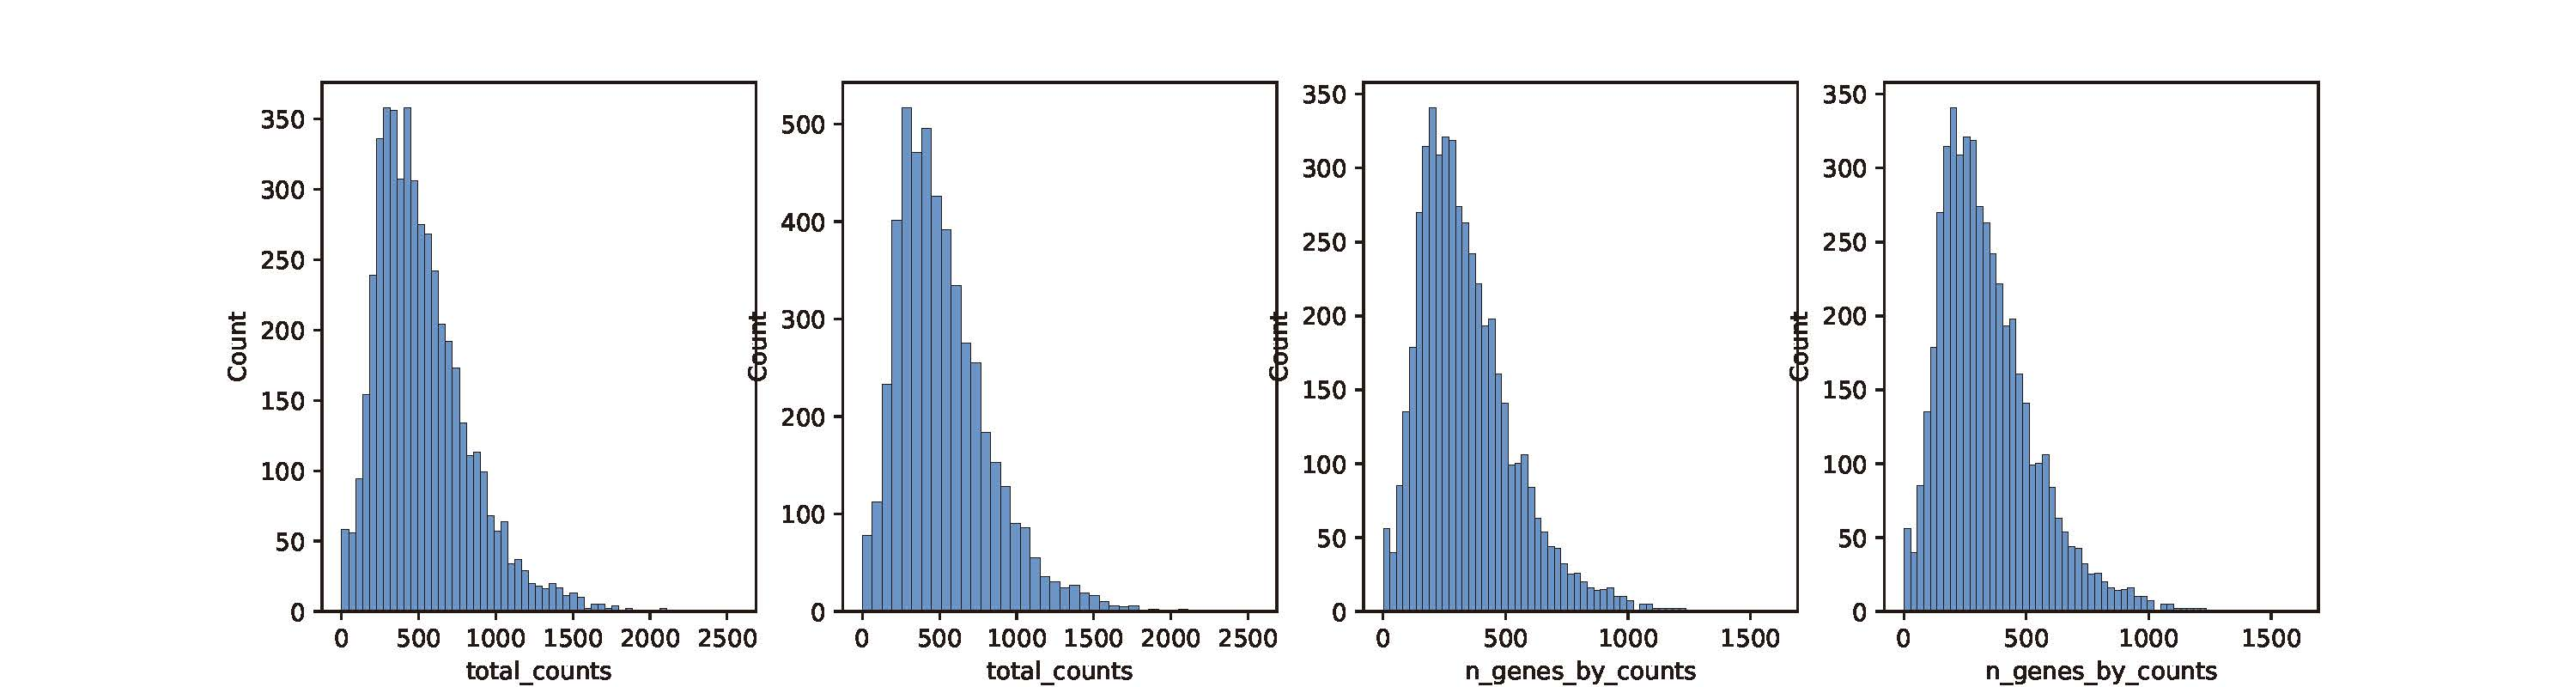

#### UMAP

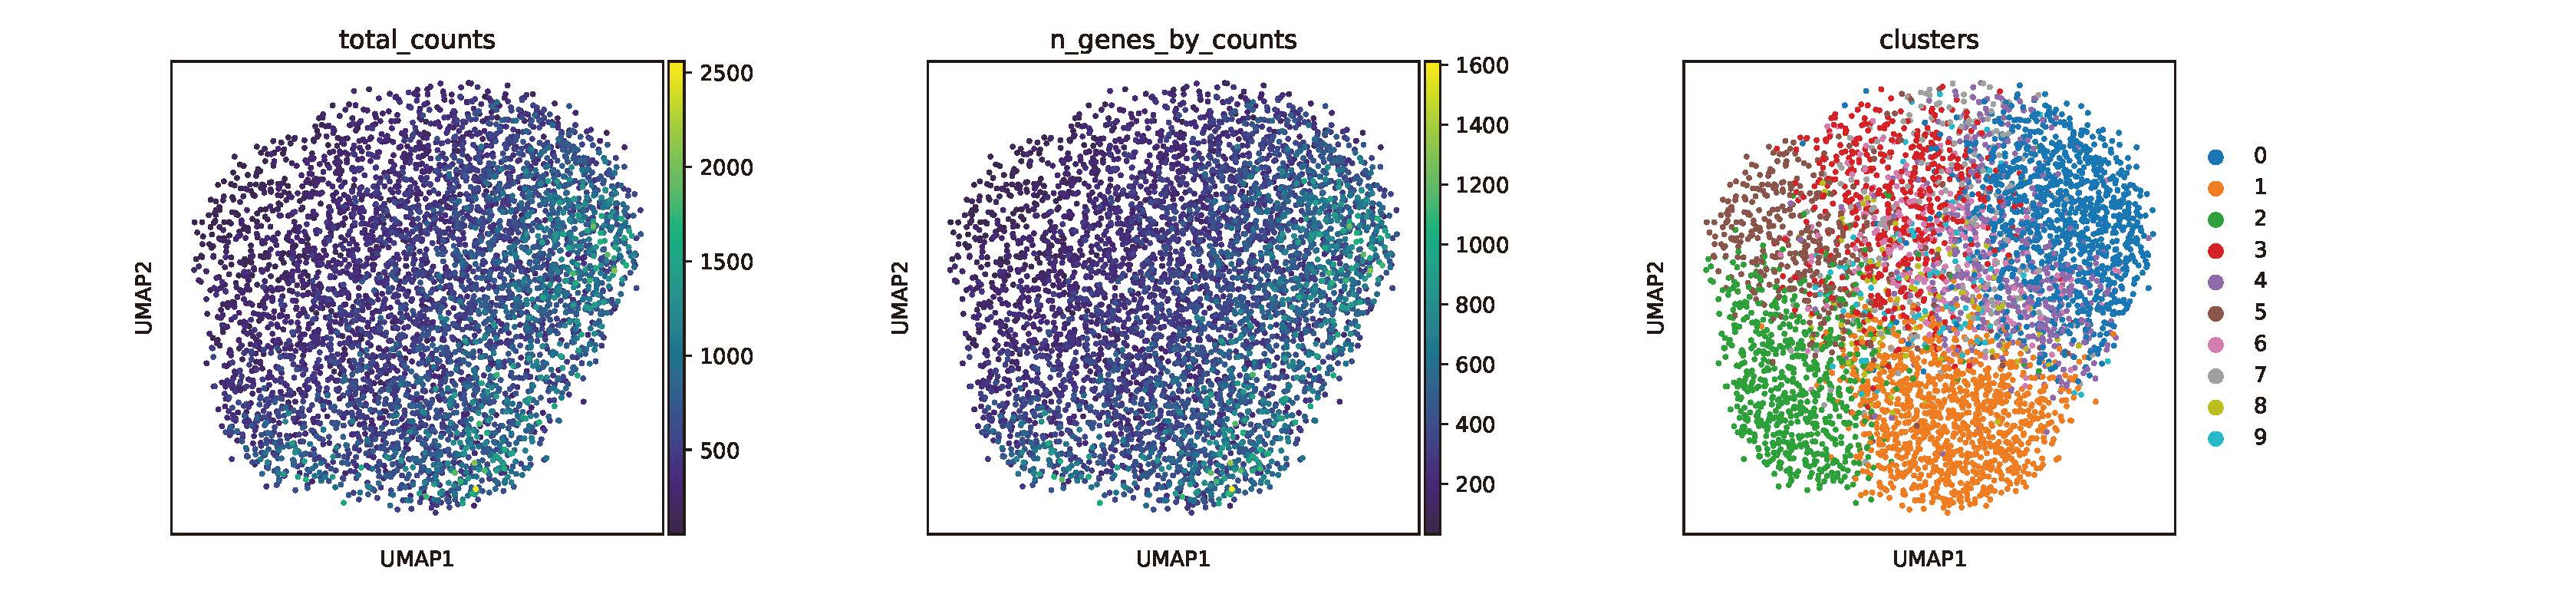

#### Spatial coordinates plot

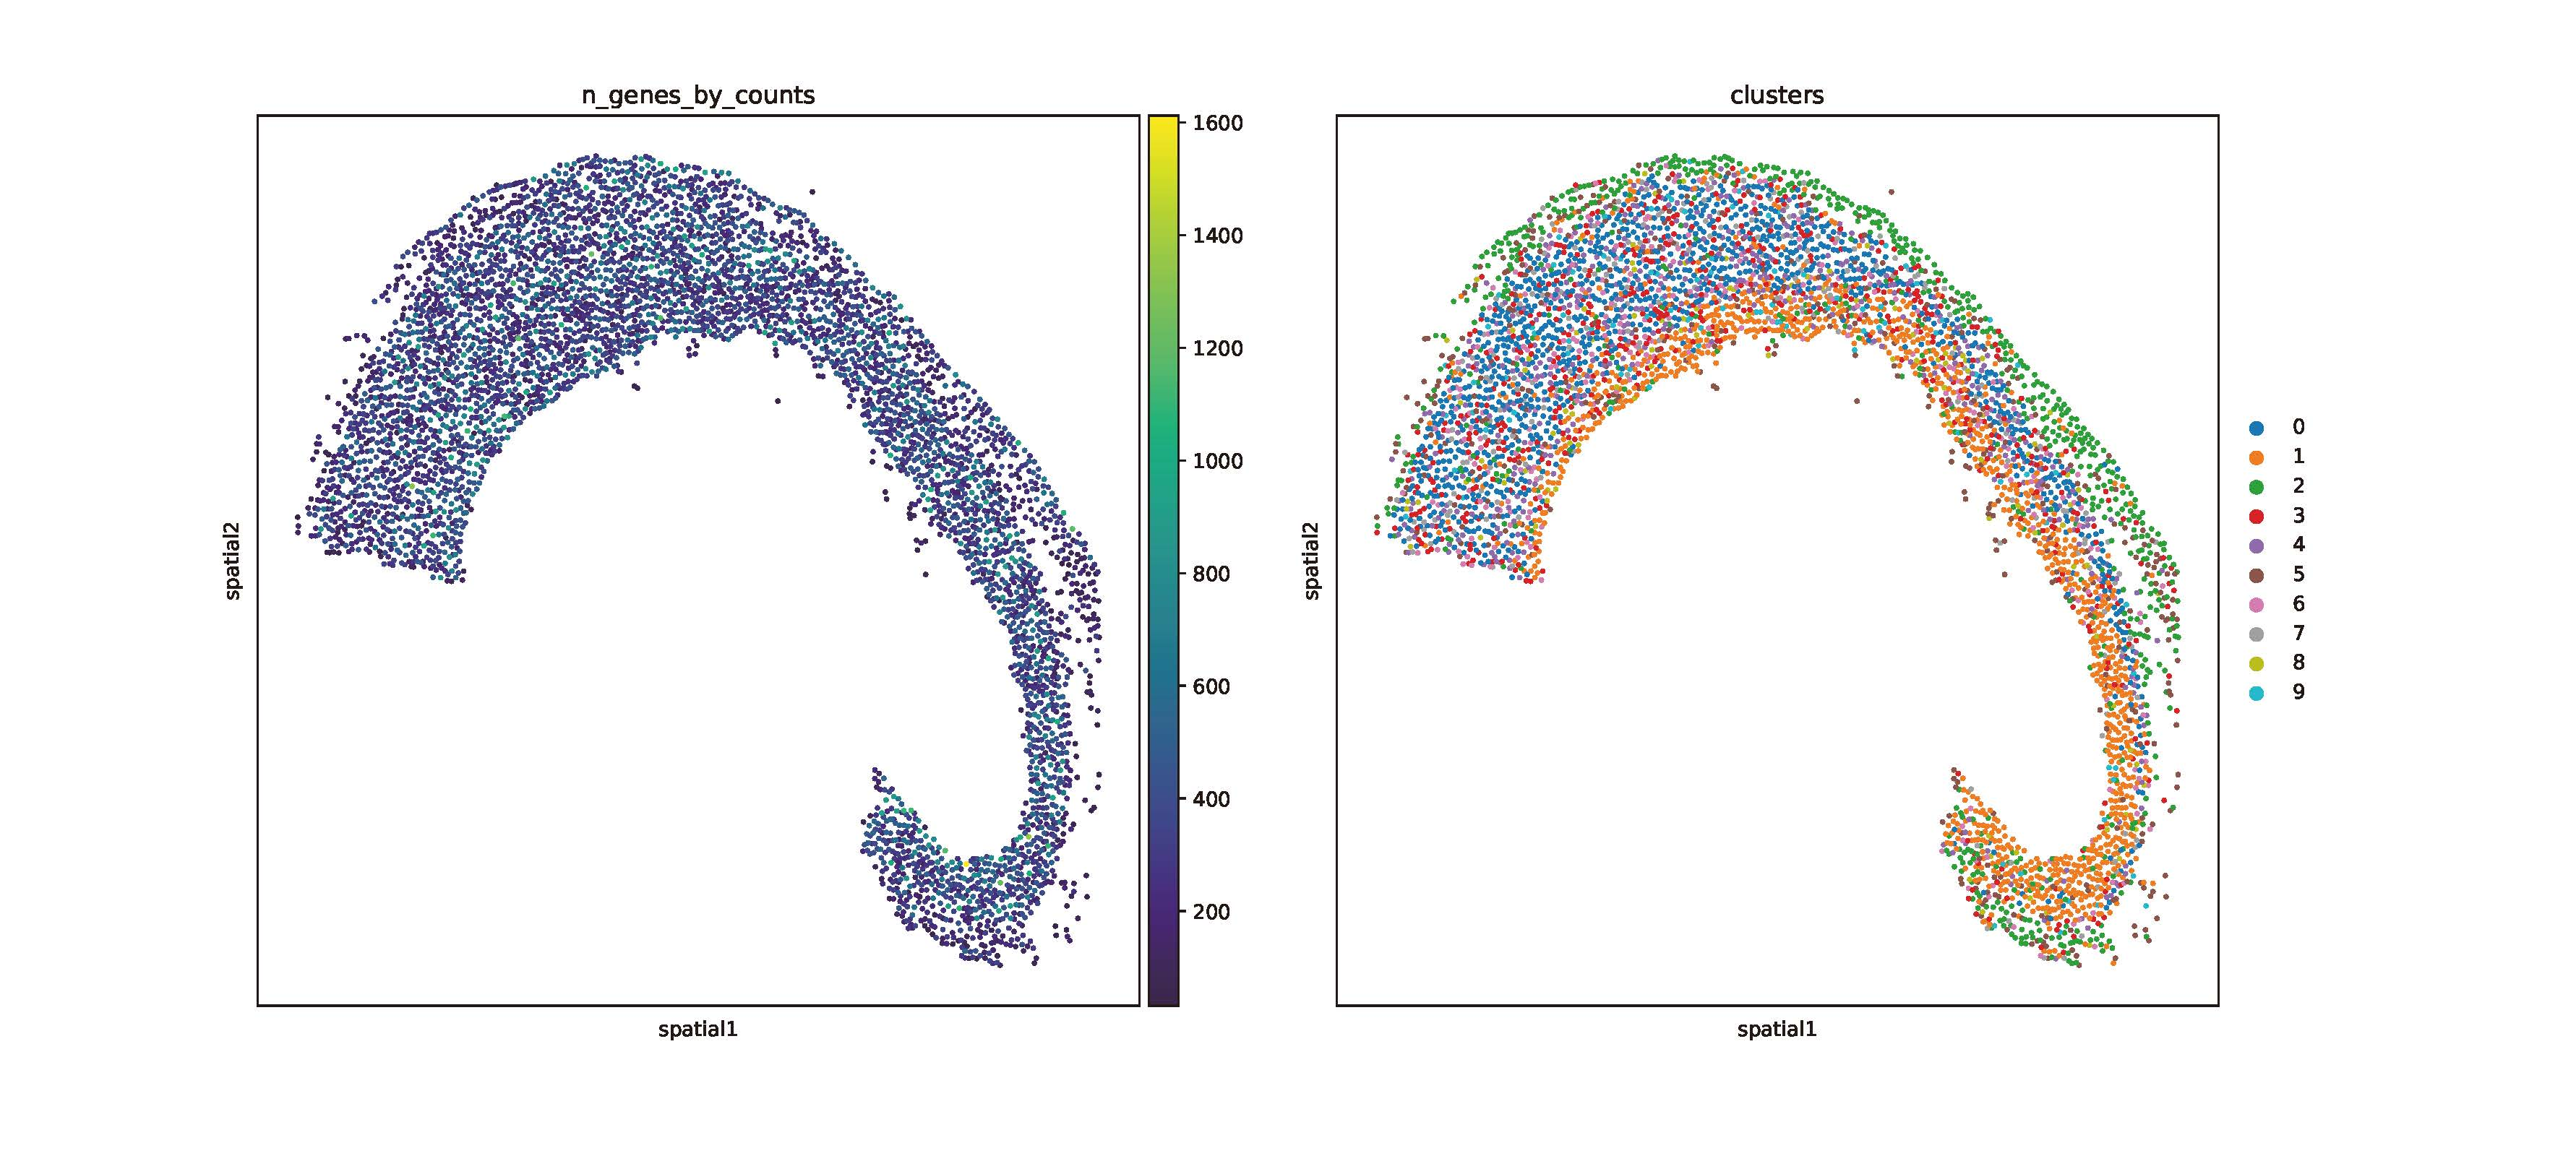

## 数据结构分析



##### 在本流程中，数据以H5AD 的格式进行了储存。请对这个数据格式的优缺点进行阐述，并尝试提出，是否有可能存在更优的数据结构方案。


答：数据以H5AD 的格式进行了储存。请对这个数据格式的优缺点进行阐述，并尝试提出，是否有可能存在更优的数据结构方案。

H5AD常用于存储单细胞RNA测序数据，是基于HDF5 (Hierarchical Data Format version 5) 的数据格式。
他的优势一般包括：1.可以灵活地存储多个实验数据，包括基因表达数据、元数据、注释信息样品信息等，且能够储存稀疏矩阵，减少存储空间和读取时间；2.具有扩展性，允许用户在存储时添加自定义元数据和注释信息，同时支持基于网格的索引结构，可以方便地进行高效的数据访问和查询；3.兼容性:H5AD是一种通用的数据格式，支持多种单细胞RNA测序分析软件，如scanpy.
Seurat、cellranger等。这使得不同软件之间的数据共享和比较变得容易。
缺点:
1.文件大小: 尽管H5AD采用了稀疏矩阵格式，但是在存储大规模单细胞RNA测序数据时它的文件大小仍然可能非常大，因此需要较大的存储空间。2.可读性:H5AD文件存储的是二进制格式的数据，不太容易人类可读，可能需要使用专业的工具或者API进行读取和解析。

其他数据结构方案：
开放式格式：开发一种基于开放标准的格式，例如JSON或XML，以增加数据的可读性和互操作性。
分布式存储：使用分布式存储技术（例如Hadoop或Spark）来存储和处理大规模单细胞RNA测序数据。
数据库：使用关系型或非关系型数据库来存储单细胞RNA测序数据，以实现更好的可扩展性和查询效率。
除了H5AD、Zarr、Anndata之外，还有一些其他的单细胞RNA测序数据格式，如10XGenomics公司推出的10X HDF5格式、CEL-Seg2公司推出的BAM格式等。这些格式都有各自的特点和优缺点，需要根据具体应用场景和需求进行选择。例如，10X HDF5格式是10XGenomics公司针对自家测序仪器开发的数据格式，可以提供更好的性能和兼容性，但是可能不大适用于其他厂家的测席数据。而BAM格式则是一种通用的测席数据格式，可以存储各种类型的测序数据，但是需要进行一定的数据处理和解析才能获取单细胞RNA测序数据。因此，选择合适的单细胞RNA测序数据格式需要考虑多方面因素，包括数据大小、存储和读取速度、兼容性、可读性等.

## 参考资料

Scanpy：
https://scanpy.readthedocs.io/en/stable/api.html
    
https://scanpy-tutorials.readthedocs.io/en/latest/spatial/basic-analysis.html
    
STAGATE：
https://stagate.readthedocs.io/en/latest/T4_Stereo.html

如何理解 AnnData ？https://blog.csdn.net/Hodors/article/details/126341127

python怎么做类型标注 https://blog.csdn.net/KWSY2008/article/details/120411751

python代码类型注解(typing) https://blog.csdn.net/weixin_44799217/article/details/125943516

broadinstitute/PhylogicNDT https://github.com/broadinstitute/PhylogicNDT

args在python中什么意思_对python中的*args与**kwgs的含义与作用详解 https://blog.csdn.net/weixin_36053084/article/details/113374600

python中的argparse模块(参数解析) https://blog.csdn.net/mydear_11000/article/details/51141679

Python标准库之argparse，详解如何创建一个ArgumentParser对象 https://baijiahao.baidu.com/s?id=1718013777590980266&wfr=spider&for=pc

Python之argparse模块的使用 https://blog.csdn.net/zong596568821xp/article/details/83027771

Argparse 教程 http://study.yali.edu.cn/pythonhelp/howto/argparse.html

argparse简介 https://blog.csdn.net/feichangyanse/article/details/128559542

python 之 tar.gz格式压缩、解压 https://blog.csdn.net/Youning_Yim/article/details/127747592

python datetime模块 格式化字符串：strftime() strptime() timedelta https://blog.csdn.net/weixin_43999327/article/details/118636816

scanpy官方教程2022||07-anndata对象：Getting started with anndata https://www.jianshu.com/p/8627435e9414

【Python】Matplotlib画布图案保存为PDF文件 https://blog.csdn.net/weixin_43896318/article/details/104507595

python将多个子图图形保存为pdf https://devpress.csdn.net/python/6300e571c677032930808823.html

python 将控制台的输出，保存到log文件中 https://blog.csdn.net/weixin_43588508/article/details/125166888

[S016]: Python print（） 信息输出到控制台，同时保存到 txt/log 文件 https://zhuanlan.zhihu.com/p/561010832

python logging模块使用教程 https://www.jianshu.com/p/feb86c06c4f4

Python中内置的日志模块logging用法详解 https://www.jb51.net/article/88449.htm

基迪奥生物 scRNA-seq分析 结题报告 https://www.omicsmart.com/10X/viewFile/129//GDI21030388_std_1/report//index.html?type=file

python装饰器传递参数_python – 如何在装饰器中传递一个变量到一个装饰函数中的函数参数？... https://blog.csdn.net/weixin_39872044/article/details/110028778

【【python】装饰器超详细教学，用尽毕生所学给你解释清楚，以后再也不迷茫了！】 https://www.bilibili.com/video/BV1Gu411Q7JV/?share_source=copy_web&vd_source=9d97e48cc8633f847eff625e512d7f04

【【python】一个公式解决所有复杂的装饰器，理解了它以后任何装饰器都易如反掌！】 https://www.bilibili.com/video/BV19U4y1d79C/?share_source=copy_web&vd_source=9d97e48cc8633f847eff625e512d7f04

sys.path.append()用法 https://blog.csdn.net/rosefun96/article/details/78909412

python脚本中的sys.path.append("..")详解 https://www.cnblogs.com/hls-code/p/15337302.html

python3中 os.path.realpath(__file__) 的使用 https://blog.csdn.net/gufenchen/article/details/90552370

Python 打印当前运行环境、获取指定文件夹下内存大小 https://developer.aliyun.com/article/933613

Python 打印当前运行环境、获取指定文件夹下内存大小 https://blog.csdn.net/weixin_42512684/article/details/115584039

python apply函数的用法_Python pandas.DataFrame.apply函数方法的使用 https://blog.csdn.net/weixin_30533943/article/details/114358838
 
使用numpy对数组求平均时如何忽略nan值 https://www.jb51.net/article/237189.htm

python数据分析包|Pandas-02之缺失值（NA）处理 https://zhuanlan.zhihu.com/p/166075497

【Python数据清洗】pivot_table 与 pivot 的区别——手把手系列 https://blog.csdn.net/qq_39885465/article/details/115485211

【Python-数据分析】如何用Python实现长宽数据的转换 https://zhuanlan.zhihu.com/p/559442802